In [1]:
from pyobo.sources.chebi import get_chebi_id_smiles_mapping
import pandas as pd
from indra_cogex.client import Neo4jClient
from rdkit.Chem import PandasTools
from rdkit import Chem, RDLogger

RDLogger.logger().setLevel(RDLogger.ERROR)
PandasTools.InstallPandasTools()

INFO: [2024-02-23 13:16:38] rdkit - Enabling RDKit 2023.03.3 jupyter extensions


In [ ]:
def write_tsv(df, path):
    columns = [c for c in df.columns if c!="molecule"]
    df[columns].to_csv(path, sep='\t', index=False)

In [2]:
chebi_smiles = get_chebi_id_smiles_mapping(version="230")

def add_smiles(xdf) -> None:
    # Add smiles, where available
    xdf["smiles"] = xdf["chemical_curie"].map(lambda s: chebi_smiles.get(s.strip('chebi:')))
    # Add nice chemical structures
    #PandasTools.AddMoleculeColumnToFrame(xdf.loc[records_df["smiles"].notna()], "smiles") # doesn't work with nones
    xdf['molecule'] = xdf['smiles'].map(lambda s: Chem.MolFromSmiles(s) if pd.notna(s) else None)
    PandasTools.ChangeMoleculeRendering(xdf)

len(chebi_smiles)

184858

In [3]:
client = Neo4jClient()

INFO: [2024-02-23 13:16:39] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2024-02-23 13:16:39] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


In [4]:
skip = {
    "chebi:39867", # valproic acid
}

## Direct Relationships

The following queries look for direct relationships between chemicals and the disease. The first cell gives a summary of relationship types, including side effects from SIDER, indications from ChEMBL, and other INDRA relationships. We skip side effects later since these seem to not make sense for cancer.

In [5]:
cypher = """\
MATCH p=(chemical:BioEntity)-[r]->(disease:BioEntity)
WHERE disease.id in ['mesh:D010190', 'doid:1793']
   AND chemical.type = 'small_molecule'
RETURN type(r), count(type(r))
"""

pd.DataFrame(client.query_tx(cypher), columns=["type", "count"])

,type,count
0,has_side_effect,3
1,has_indication,186
2,indra_rel,392


In [6]:
cypher = """\
MATCH p=(chemical:BioEntity)-[r]->(disease:BioEntity)
WHERE disease.id in ['mesh:D010190', 'doid:1793']
   AND chemical.type = 'small_molecule'
   AND type(r) <> "has_side_effect"
RETURN chemical.id, chemical.name, collect(DISTINCT type(r))
"""

direct_df = pd.DataFrame(client.query_tx(cypher), columns=["chemical_curie", "chemical_name", "types"])
add_smiles(direct_df)
direct_df = direct_df[~direct_df['chemical_curie'].isin(skip)]
write_tsv(direct_df, "direct.tsv",e)
direct_df

[13:16:41] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:16:41] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:16:41] Explicit valence for atom # 0 N, 4, is greater than permitted


,chemical_curie,chemical_name,types,smiles,molecule
0,chebi:95044,(2S)-2-[[(2R)-2-[(1S)-1-hydroxy-2-(hydroxyamin...,[has_indication],CC(C)C[C@H]([C@@H](C(=O)NO)O)C(=O)N[C@@H](C1=C...,<rdkit.Chem.rdchem.Mol object at 0x2a16d0ac0>
1,chebi:94291,2-(butan-2-yldisulfanyl)-1H-imidazole,[has_indication],CCC(C)SSC1=NC=CN1,<rdkit.Chem.rdchem.Mol object at 0x2a16d0ba0>
2,chebi:9421,tazobactam,[has_indication],C[C@]1(Cn2ccnn2)[C@@H](N2[C@@H](CC2=O)S1(=O)=O...,<rdkit.Chem.rdchem.Mol object at 0x2a16d06d0>
3,chebi:93752,"(2S)-N1-[4-methyl-5-[2-(1,1,1-trifluoro-2-meth...",[has_indication],CC1=C(SC(=N1)NC(=O)N2CCC[C@H]2C(=O)N)C3=CC(=NC...,<rdkit.Chem.rdchem.Mol object at 0x2a16d1b60>
4,chebi:9168,sirolimus,"[has_indication, indra_rel]",[H][C@]1(CC[C@@H](O)[C@@H](C1)OC)C[C@@H](C)[C@...,<rdkit.Chem.rdchem.Mol object at 0x2a16d1af0>
...,...,...,...,...,...
434,chebi:134609,nitrosobis(2-oxopropyl)amine,[indra_rel],N(N=O)(CC(C)=O)CC(C)=O,<rdkit.Chem.rdchem.Mol object at 0x2a138b060>
435,chebi:132992,radiosensitizing agent,[indra_rel],None,None
436,chebi:113532,thymoquinone,[indra_rel],CC(C)C1=CC(=O)C(C)=CC1=O,<rdkit.Chem.rdchem.Mol object at 0x2a138aff0>
437,chebi:156287,CX-5461,[indra_rel],CN1CCCN(CC1)C1=NC2=C(C=C1)C(=O)C(C(=O)NCC1=CN=...,<rdkit.Chem.rdchem.Mol object at 0x2a138af80>


## Get Genes for Disease

The following query gets all of the genes that are associated with the disease, as a summary. The gene-disease relationships come from a combination of 1) DisGeNet associations and 2) INDRA statements.

Below, we will leverage various ways these are conected to chemicals.

In [7]:
cypher = """\
    MATCH p=(gene:BioEntity)-[r]-(disease:BioEntity)
    WHERE disease.id in ['mesh:D010190', 'doid:1793']
       AND gene.type = 'human_gene_protein'
    RETURN DISTINCT gene.id, gene.name, collect(DISTINCT type(r))
    ORDER BY gene.id
"""

gene_associations = client.query_tx(cypher)
gene_associations_df = pd.DataFrame(gene_associations, columns=['gene_curie', 'gene_name', "types"])
gene_associations_df.to_csv("genes.tsv", sep='\t', index=False)
gene_associations_df

,gene_curie,gene_name,types
0,hgnc:10019,RIPK1,[indra_rel]
1,hgnc:10020,RIPK2,[indra_rel]
2,hgnc:10021,RIPK3,[indra_rel]
3,hgnc:10046,RNASE3,[indra_rel]
4,hgnc:10069,RNF6,[indra_rel]
...,...,...,...
972,mesh:D009077,Mucins,[indra_rel]
973,mesh:D011451,Prostaglandin-Endoperoxide Synthases,[indra_rel]
974,mesh:D016333,HIV Protease,[indra_rel]
975,mesh:D053668,Syndecan-1,[indra_rel]


## Get Relationships via Gene/Protein Interactions

The following query extends the previous gene query to find all of the chemicals affecting the genes. The chemical-gene relationships primary come from INDRA statements.

In [8]:
# This query gets the genes/chemicals associated with pancreatic cancer
cypher = """\
    MATCH p=(chemical:BioEntity)-[]->(gene:BioEntity)-[]-(disease:BioEntity)
    WHERE disease.id in ['mesh:D010190', 'doid:1793']
       AND gene.type = 'human_gene_protein'
       AND chemical.type = 'small_molecule'
    RETURN chemical.id, chemical.name, count(DISTINCT gene.id) as n_genes
    ORDER BY n_genes DESC
"""

records = client.query_tx(cypher, )
records_df = pd.DataFrame(records, columns=['chemical_curie', 'chemical_name', 'n_unique_genes'])
records_df = records_df[~records_df['chemical_curie'].isin(skip)]

[13:16:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:16:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:16:53] Explicit valence for atom # 2 O, 3, is greater than permitted
[13:16:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:16:53] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:16:53] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:16:53] Explicit valence for atom # 9 N, 4, is greater than permitted
[13:16:53] Explicit valence for atom # 34 N, 4, is greater than permitted
[13:16:53] Explicit valence for atom # 7 O, 3, is greater than permitted
[13:16:53] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:16:54] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:16:54] Explicit valence for atom # 0 N, 4, is greater than permitted
[13:16:54] Explicit valence for atom # 4 O, 3, is greater than permitted
[13:16:54] Explicit valence for atom # 9 N, 4, is

,chemical_curie,chemical_name,n_unique_genes,smiles,molecule
0,chebi:33216,bisphenol A,917,CC(C)(C1=CC=C(O)C=C1)C1=CC=C(O)C=C1,
2,chebi:28119,"2,3,7,8-tetrachlorodibenzodioxine",756,Clc1cc2Oc3cc(Cl)c(Cl)cc3Oc2cc1Cl,
3,chebi:29865,benzo[a]pyrene,751,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,
4,chebi:27899,cisplatin,707,[H][N]([H])([H])[Pt](Cl)(Cl)[N]([H])([H])[H],None
5,chebi:4031,cyclosporin A,705,CC[C@@H]1NC(=O)[C@H]([C@H](O)[C@H](C)C\\C=C\\C...,
...,...,...,...,...,...
15328,chebi:37887,adrenergic antagonist,1,None,None
15329,chebi:31945,Oxeladin citrate,1,None,None
15330,chebi:27909,paraldehyde,1,CC1OC(C)OC(C)O1,
15331,chebi:26394,purine nucleoside,1,None,None

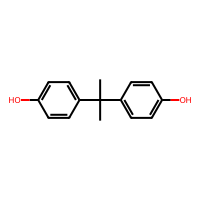
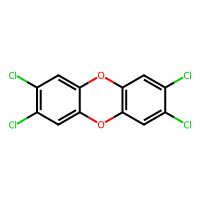
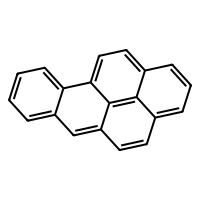
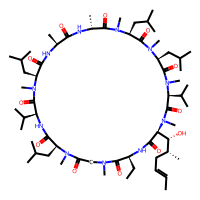
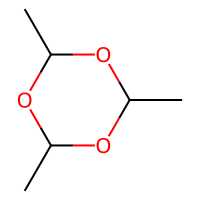
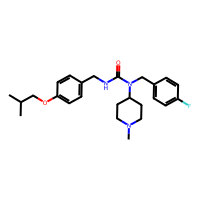

In [9]:
add_smiles(records_df)

records_df.to_csv("chemical_gene_disease.tsv", sep='\t', index=False)
records_df